In [271]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yfin
import math
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm
import scipy.stats
from sklearn.decomposition import PCA
from patsy import dmatrices
import matplotlib_inline.backend_inline 

matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')

plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

In [272]:
data = pd.read_csv('stockdata.csv', low_memory=False)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp')

aapl = data[data['symbol']=='AAPL']
jpm = data[data['symbol']=='JPM']

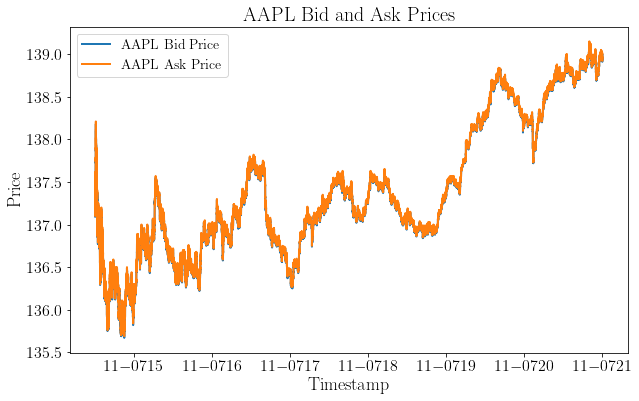

In [273]:
# 1.1 AAPL Stock Prices

aapl_bid = aapl['bid']
aapl_ask = aapl['ask']

plt.plot(aapl_bid, label="AAPL Bid Price")
plt.plot(aapl_ask, label="AAPL Ask Price")
plt.title("AAPL Bid and Ask Prices")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()
plt.show()

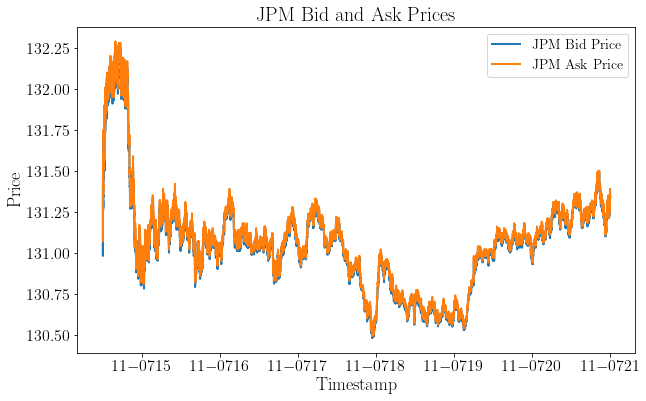

In [274]:
# 1.1 JPM Stock Prices

jpm_bid = jpm['bid']
jpm_ask = jpm['ask']

plt.plot(jpm_bid, label="JPM Bid Price")
plt.plot(jpm_ask, label="JPM Ask Price")
plt.title("JPM Bid and Ask Prices")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()
plt.show()

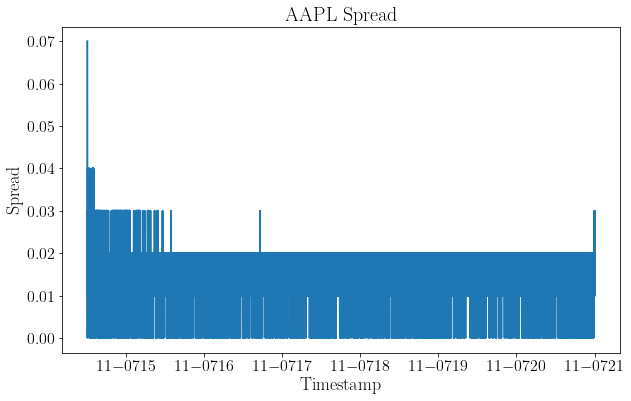

In [275]:
# 1.2 AAPL Stock Spread

aapl_spread = aapl_ask - aapl_bid

plt.plot(aapl_spread)
plt.title("AAPL Spread")
plt.xlabel("Timestamp")
plt.ylabel("Spread")
plt.show()

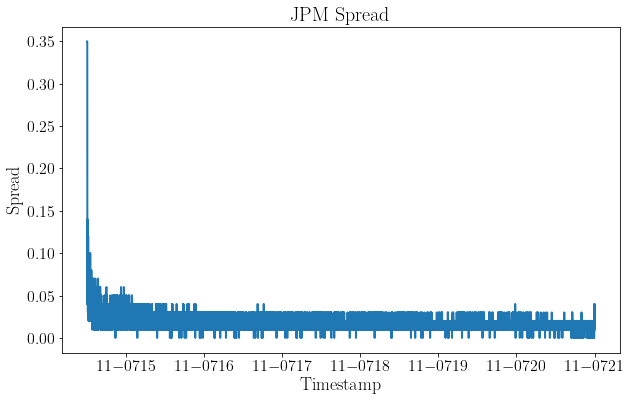

In [276]:
# 1.2 JPM Stock Spread

jpm_spread = jpm_ask - jpm_bid

plt.plot(jpm_spread)
plt.title("JPM Spread")
plt.xlabel("Timestamp")
plt.ylabel("Spread")
plt.show()

Both spreads of AAPL and JPM do not have that much variance. We see this with the majority of AAPL's spread falling within 0.02 and JPM's falling within 0.03. It is also evident that both stocks have greater divergence between their ask and bid prices at the beginning of the day, converging fairly early in the day. A major difference between the spreads of AAPL and JPM is that JPM seems to have a greater disparity at the beginning of the day than AAPL. As seen in the graphs, AAPL's maximum spread is 0.07 while JPM's maximum spread is 0.35.

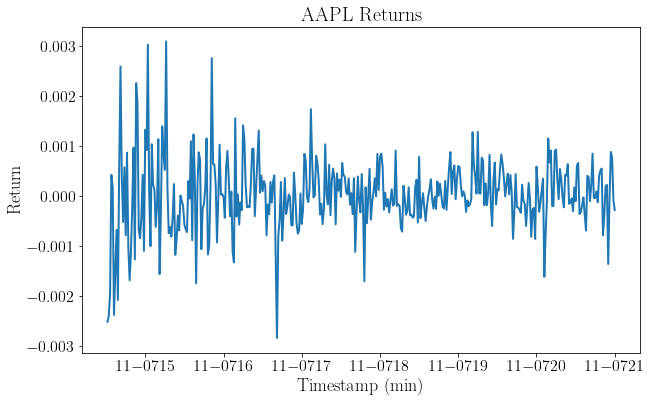

In [277]:
# 1.3 AAPL Stock Returns

aapl_minute = aapl.resample('T').mean()

aapl_bid_minute = aapl_minute['bid']
aapl_ask_minute = aapl_minute['ask']

aapl_midprices_minute = 0.5 * (aapl_ask_minute + aapl_bid_minute)

aapl_returns_minute = aapl_midprices_minute.pct_change().drop(['2022-11-07 09:30:00-05:00'])

aapl_minute['returns'] = aapl_returns_minute
    
plt.plot(aapl_returns_minute)
plt.title("AAPL Returns")
plt.xlabel("Timestamp (min)")
plt.ylabel("Return")
plt.show()

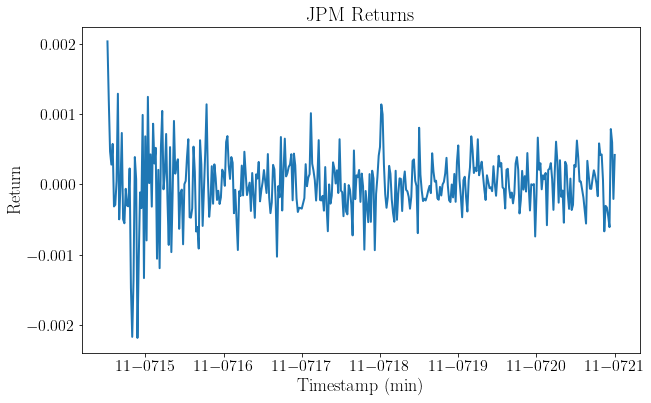

In [278]:
# 1.3 JPM Stock Returns

jpm_minute = jpm.resample('T').mean()

jpm_bid_minute = jpm_minute['bid']
jpm_ask_minute = jpm_minute['ask']

jpm_midprices_minute = 0.5 * (jpm_ask_minute + jpm_bid_minute)

jpm_returns_minute = jpm_midprices_minute.pct_change().drop(['2022-11-07 09:30:00-05:00'])

jpm_minute['returns'] = jpm_returns_minute
    
plt.plot(jpm_returns_minute)
plt.title("JPM Returns")
plt.xlabel("Timestamp (min)")
plt.ylabel("Return")
plt.show()

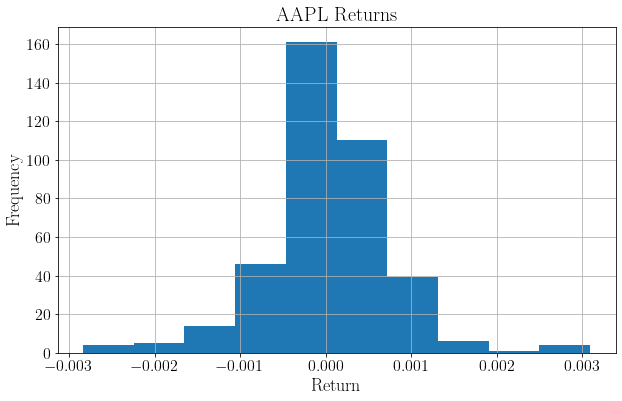

In [279]:
# 1.4 AAPL Returns Histogram

aapl_minute.hist(column='returns', bins=10)
plt.title("AAPL Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

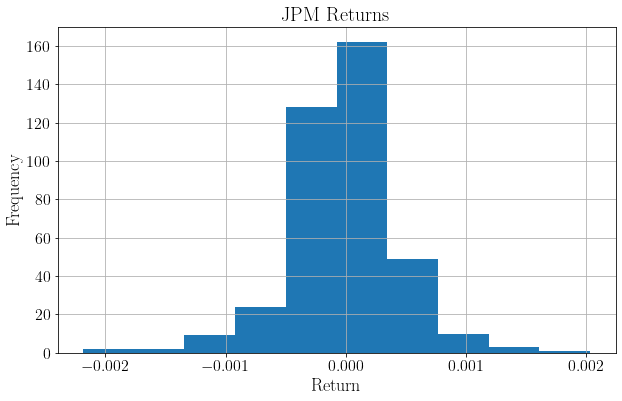

In [280]:
# 1.4 JPM Returns Histogram

jpm_minute.hist(column='returns',bins=10)
plt.title("JPM Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

The returns for both AAPL and JPM do not look normally distributed though they are not that far off.

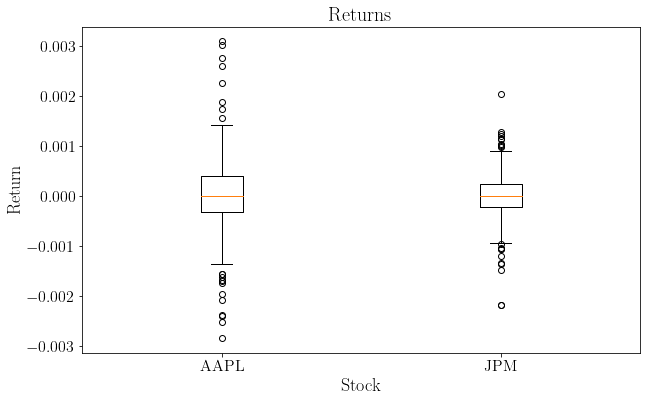

In [281]:
# 1.5 Returns Boxplot

fig = plt.figure()
plt.boxplot([aapl_returns_minute, jpm_returns_minute], labels=['AAPL', 'JPM'])
plt.title("Returns")
plt.xlabel("Stock")
plt.ylabel("Return")
plt.show()

AAPL returns have more variance, generally being spread out between -0.003 and 0.003. JPM returns are heavily concentrated between -0.0015 and 0.0015 with 2 outliers around -0.0025 and 0.0025. 

2.1 Kurtosis 

![2.1 Kurtosis](2.jpeg)

In [283]:
# 2.2 AAPL Kurtosis

aapl_mean = sum(aapl_returns_minute) / len(aapl_returns_minute)

aapl_num = []
aapl_den = []

for aapl_return in aapl_returns_minute: 
        aapl_num.append((aapl_return - aapl_mean) ** 4)
        aapl_den.append((aapl_return - aapl_mean) ** 2)

aapl_num = sum(aapl_num) / len(aapl_returns_minute)
aapl_den = (sum(aapl_den) / len(aapl_returns_minute)) ** 2

aapl_kurtosis = aapl_num / aapl_den

aapl_kurtosis

6.233684507047202

In [284]:
# 2.2 JPM Kurtosis

jpm_mean = sum(jpm_returns_minute) / len(jpm_returns_minute)

jpm_num = []
jpm_den = []

for jpm_return in jpm_returns_minute: 
        jpm_num.append((jpm_return - jpm_mean) ** 4)
        jpm_den.append((jpm_return - jpm_mean) ** 2)

jpm_num = sum(jpm_num) / len(jpm_returns_minute)
jpm_den = (sum(jpm_den) / len(jpm_returns_minute)) ** 2

jpm_kurtosis = jpm_num / jpm_den

jpm_kurtosis

6.702597010351448

Looking at both the histograms and kurtoses, we can see that both AAPL and JPM have slightly heavier tails than a normal distribution. This makes sense with the excess positive kurtoses of 3.234 and 3.703 respectively. 

In [285]:
# 2.3 AAPL Jarque-Bera Test

aapl_JB = jarque_bera(aapl_returns_minute)

aapl_JB

(170.4642065521043,
 9.642016408173354e-38,
 0.09136400751110617,
 6.233684507047197)

In [286]:
# 2.3 JPM Jarque-Bera Test

jpm_JB = jarque_bera(jpm_returns_minute)

jpm_JB

(232.35302412859005,
 3.5089880055574915e-51,
 -0.3838694496892741,
 6.702597010351448)

The null hypothesis for the JB test is $$ H_0 = \alpha \\ if \\ JB \le {x_{1-\alpha, 2}}^2 $$. The asymptotic distribution of the test statistic is Chi-squared because JB is the sum of squares of two asymptotically independent normals.

AAPl p-value: 9.642 * 10^-38 

JPM p-value: 3.509 * 10^-51

I would assume the null hypothesis would be rejected since the p-values for both stocks are extremely small and the JB test statistics are large.

In [319]:
# 3.1 Resampled Return Series

intervals = ['0.5S', '1S', '10S', '20S', '30S', '40S', '50S', '60S', '120S', '300S']

aapl_returns = {}
jpm_returns = {}

for interval in intervals: 
    aapl_midprices = 0.5 * (aapl['ask'] + aapl['bid'])
    aapl_resampled = aapl_midprices.resample(interval).mean()

    aapl_returns[interval] = np.log(aapl_resampled) - np.log(aapl_resampled.shift(1))

    jpm_midprices = 0.5 * (jpm['ask'] + jpm['bid'])
    jpm_resampled = jpm_midprices.resample(interval).mean()

    jpm_returns[interval] = np.log(jpm_resampled) - np.log (jpm_resampled.shift(1))
    

In [322]:
# 3.2 Correlation Between AAPL and JPM

correlations = [aapl_returns[interval].corr(jpm_returns[interval]) for interval in intervals]

correlations

[0.3035786729433374,
 0.3386035546195109,
 0.35817305692800017,
 0.30230760088324604,
 0.2854929679193982,
 0.25276890103023975,
 0.2166319015269269,
 0.2207851169706437,
 0.12603177367357504,
 0.2219970573661168]

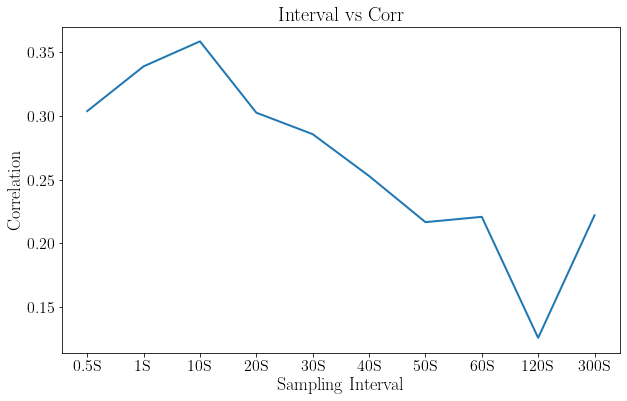

In [323]:
# 3.3 Sampling Interval vs Correlation Plot

plt.plot(intervals, correlations)
plt.title("Interval vs Corr")
plt.xlabel("Sampling Interval")
plt.ylabel("Correlation")
plt.show()

4.1 PDF of T

![4.1 PDF of T](4_1.jpeg)

4.2 Relationship Between T and Z

T and Z have the same PDF as they are both Cauchy distributions. Further if X = sin(U) and Y = cos(U), then T = tan(U) = U. 

4.3 Expected Value of Z

![4.3 Expected Value of Z](4_3.jpeg)

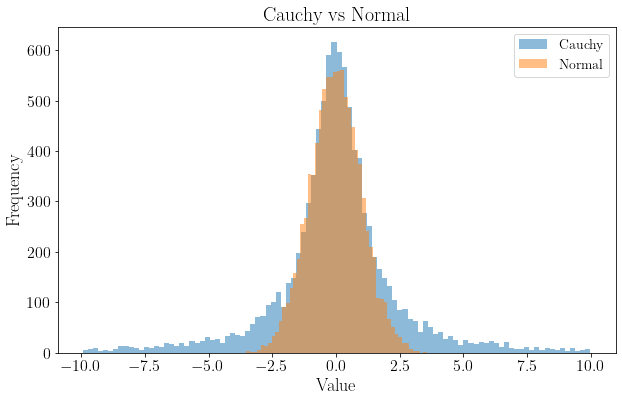

In [290]:
# 4.4 Cauchy vs Normal Distribution 
cauchy = np.random.standard_cauchy(10000)
cauchy = cauchy[(cauchy>-10) & (cauchy<10)] 
normal = np.random.normal(0, 1, 10000)

plt.hist(cauchy, bins=100, alpha=0.5, label="Cauchy")
plt.hist(normal, bins=50, alpha=0.5, label="Normal")
plt.title('Cauchy vs Normal')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In the histogram, it is clear that Z which is the Cauchy distribution has heavier tails than the normal distribution. 

In [291]:
# 4.5 Normal Max Value 
max(normal)

3.5794082310949755

In [292]:
# 4.5 Cauchy Max Value
max(cauchy)

9.98231165357816

In [293]:
# 4.5 Samples to Get 20

1/scipy.stats.norm(0, 1).cdf(-20)

3.63157772058659e+88

To get the number of iid samples from N(0,1) that you would need to have a maximum of 20, we can model this event as a first success distribution where X is a random variable for the event that 20 appears from the samples. Hence the expected number of samples it would take can be found by 1/p where p is the probability that 20 appears. As seen above, the expected number of trials or samples is 3.632 * 10^88. 

[*********************100%***********************]  1 of 1 completed


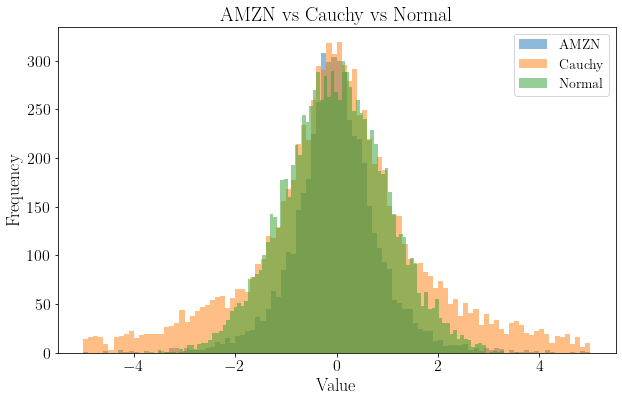

In [294]:
# 4.6 AMZN Returns
amzn = yfin.download(tickers='AMZN', period ='20y', interval='1d')
amzn_returns = amzn['Close'].pct_change().fillna(method='bfill')

std_amzn = np.std(amzn_returns)
mean_amzn = np.mean(amzn_returns)

amzn_returns = (amzn_returns - mean_amzn) / std_amzn

cauchy = cauchy[(cauchy>-5) & (cauchy<5)] 

plt.hist(amzn_returns, bins=100, alpha=0.5, range = (-5, 5), label="AMZN")
plt.hist(cauchy, bins=100, alpha=0.5, label="Cauchy")
plt.hist(normal, bins=100, alpha=0.5, label="Normal")
plt.title('AMZN vs Cauchy vs Normal')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The distribution of AMZN returns seems to be in between the normal and Cauchy distributions, having heavier tails than the normal distribution but lighter tails than the Cauchy distribution. 

[*********************100%***********************]  1 of 1 completed


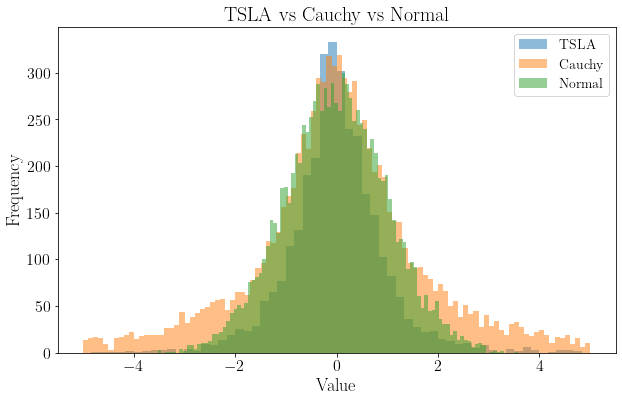

In [295]:
# 4.6 TSLA Returns
tsla = yfin.download(tickers='TSLA', period ='30y', interval='1d')
tsla_returns = tsla['Close'].pct_change().fillna(method='bfill')

std_tsla = np.std(tsla_returns)
mean_tsla = np.mean(tsla_returns)

tsla_returns = (tsla_returns - mean_tsla) / std_tsla

plt.hist(tsla_returns, bins=60, alpha=0.5, range = (-5, 5), label="TSLA")
plt.hist(cauchy, bins=100, alpha=0.5, label="Cauchy")
plt.hist(normal, bins=100, alpha=0.5, label="Normal")
plt.title('TSLA vs Cauchy vs Normal')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The distribution of TSLA returns seems a little closer to the Cauchy distribution as its tails are heavier. 

5 Multivariate Gaussians

![](5_1.jpeg)

![](5_2.jpeg)

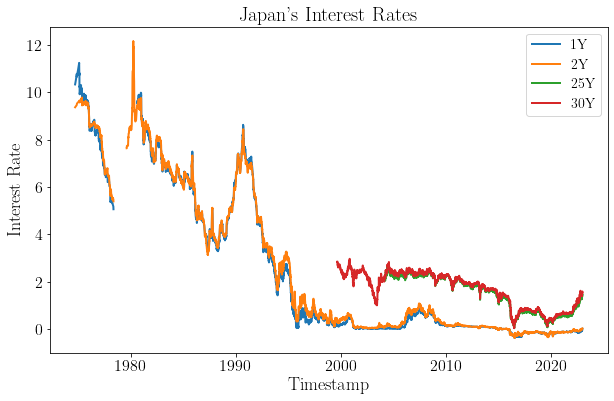

In [296]:
# 6.1 Japan's Short vs Long Term Rates 

japan = pd.read_csv('japan.csv', na_values=["-"], low_memory=False, parse_dates=["Date"]).set_index("Date")

plt.plot(japan['1Y'], label="1Y")
plt.plot(japan['2Y'], label="2Y")
plt.plot(japan['25Y'], label="25Y")
plt.plot(japan['30Y'], label="30Y")
plt.title("Japan's Interest Rates")
plt.xlabel("Timestamp")
plt.ylabel("Interest Rate")
plt.legend()
plt.show()

We can see that Japan's long term rates are about double its short term rates. Additionally in the past 20 years, Japan's long term rates have had drops around 2003, 2007, and 2020 while its short term rates have been extremely consistent with a temporary increase from 2007 - 2009. 

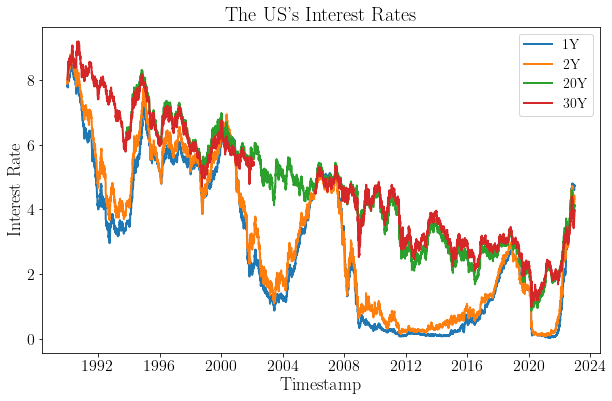

In [297]:
# 6.1 The US's Short and Long Term Rates

df_rates = pd.read_csv("df_rates.csv",na_values=["0.0"], parse_dates=["date"]).set_index("date")

plt.plot(df_rates['BC_1YEAR'], label="1Y")
plt.plot(df_rates['BC_2YEAR'], label="2Y")
plt.plot(df_rates['BC_20YEAR'], label="20Y")
plt.plot(df_rates['BC_30YEAR'], label="30Y")
plt.title("The US's Interest Rates")
plt.xlabel("Timestamp")
plt.ylabel("Interest Rate")
plt.legend()
plt.show()

We can see that for the past 30 years, US long term and short term rates periodically converge along a downward trend. Long term rates have declined consistently while short term rates go through drastic drops and then rebound. In the last few years, these rates have converged again and been on the increase.  

In [298]:
# 6.2 Japan's Yield Curves

class NSCurveFamily:
        
    def __init__(self, useNSS=False):
        ''' True if Nelson Siegel Svensson Model
            False if Nelson Siegel Model
        '''
        self.useNSS = useNSS
        self.HasEstParam = False

    def fitNSModel(self, tau, t_seq, zr_seq):
        '''
        Use the simple weighted OLS with the weight proportional to the tenor between data points       
        ''' 
        t_to_tau = [ t/tau  for t in t_seq]
        xterm1 = [ (1.0-math.exp(-tt))/tt for tt in t_to_tau]
        xterm2 = [ (1.0-math.exp(-tt))/tt-math.exp(-tt) for tt in t_to_tau]
        x = np.array([xterm1, xterm2]).T
        x = sm.add_constant(x)
        wt=np.append(t_seq[0],np.diff(t_seq))      
        res = sm.WLS(zr_seq, x, wt).fit()
        return (res.params, res.rsquared)    
    
    def fitNSSModel(self, tau1, tau2, t_seq, zr_seq):
        '''
        Use the simple weighted OLS with the weight proportional to the tenor between data points       
        ''' 
        t_to_tau1 = [ t/tau1  for t in t_seq]
        t_to_tau2 = [ t/tau2  for t in t_seq]

        xterm1 = [ (1.0-math.exp(-tt))/tt for tt in t_to_tau1]
        xterm2 = [ (1.0-math.exp(-tt))/tt-math.exp(-tt) for tt in t_to_tau1]
        xterm3 = [ (1.0-math.exp(-tt))/tt-math.exp(-tt) for tt in t_to_tau2]

        x = np.array([xterm1, xterm2, xterm3]).T
        x = sm.add_constant(x)
        wt=np.append(t_seq[0],np.diff(t_seq))      
        res = sm.WLS(zr_seq, x, wt).fit()
        return (res.params, res.rsquared)
         
    def estNSParam(self, t_seq, zr_seq):
        tau_univ = [1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]                
        rsq_univ = [ self.fitNSModel(tau, t_seq, zr_seq)[1] for tau in tau_univ]
        opt_tau = tau_univ[np.argmax(rsq_univ)]
        opt_param, opt_rsqr = self.fitNSModel(opt_tau, t_seq, zr_seq)
        return (opt_param, opt_tau, opt_rsqr)
    
    def estNSSParam(self, t_seq, zr_seq):
        tau_univ = [1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
        nTau = len(tau_univ)
        rsq_univ = np.array([ self.fitNSSModel(tau0, tau1, t_seq, zr_seq)[1] for tau0 in tau_univ for tau1 in tau_univ])
        rsq_univ = rsq_univ.reshape((nTau,nTau))    
        maxidx = np.argmax(rsq_univ)
        opt_tau0, opt_tau1 = tau_univ[maxidx // nTau], tau_univ[maxidx % nTau]
        opt_param, opt_rsqr = self.fitNSSModel(opt_tau0, opt_tau1, t_seq, zr_seq)
        return (opt_param, opt_tau0, opt_tau1, opt_rsqr)    

    def estimateParam(self, t_seq, zr_seq):
        ''' parameter estimation based on grid search 
        t_seq:  time in year
        zr_seq: spot rate 
        '''        
        if self.useNSS:
            param, tau0, tau1, rsqr = self.estNSSParam(t_seq, zr_seq)
            self.beta0, self.beta1, self.beta2, self.beta3=param
            self.tau0, self.tau1, self.rsqr = tau0, tau1, rsqr
        else:
            param, tau, rsqr = self.estNSParam(t_seq, zr_seq)
            self.beta0, self.beta1, self.beta2=param
            self.tau0, self.rsqr = tau, rsqr
            self.tau1, self.beta3 = float('nan'), float('nan')
        self.HasEstParam=True
        
    def getSpot(self, t_seq):
        ''' Return the spot rate based upon the estimated yield curve
        t_seq: time in year
        ''' 
        if self.HasEstParam == False:
            raise Exception('Parameters are not available')
        if self.useNSS:
            t_to_tau1 = [ t/self.tau0  for t in t_seq]
            t_to_tau2 = [ t/self.tau1  for t in t_seq]
            xterm1 = [ (1.0-math.exp(-tt))/tt for tt in t_to_tau1]
            xterm2 = [ (1.0-math.exp(-tt))/tt-math.exp(-tt) for tt in t_to_tau1]
            xterm3 = [ (1.0-math.exp(-tt))/tt-math.exp(-tt) for tt in t_to_tau2]
            param = [self.beta0, self.beta1, self.beta2, self.beta3]
            x = np.array([xterm1, xterm2, xterm3]).T
            x = sm.add_constant(x)
        else:
            t_to_tau = [ t/self.tau0  for t in t_seq]
            xterm1 = [ (1.0-math.exp(-tt))/tt for tt in t_to_tau]
            xterm2 = [ (1.0-math.exp(-tt))/tt-math.exp(-tt) for tt in t_to_tau]
            param = [self.beta0, self.beta1, self.beta2]
            x = np.array([xterm1, xterm2]).T
            x = sm.add_constant(x)
        return x.dot(param)
        

    def getFwdRate(self, t_seq):
        ''' Return the forward rate based upon the estimated yield curve
        t_seq: time in year
        ''' 
        if self.HasEstParam == False:
            raise Exception('Parameters are not available')
        if self.useNSS:
            t_to_tau1 = [ t/self.tau0  for t in t_seq]
            t_to_tau2 = [ t/self.tau1  for t in t_seq]
            xterm1 = [ math.exp(-tt) for tt in t_to_tau1]
            xterm2 = [ tt*math.exp(-tt) for tt in t_to_tau1]
            xterm3 = [ tt*math.exp(-tt) for tt in t_to_tau2]
            param = [self.beta0, self.beta1, self.beta2, self.beta3]
            x = np.array([xterm1, xterm2, xterm3]).T
            x = sm.add_constant(x)
        else:
            t_to_tau = [ t/self.tau0  for t in t_seq]
            xterm1 = [ math.exp(-tt) for tt in t_to_tau]
            xterm2 = [ tt*math.exp(-tt) for tt in t_to_tau]
            param = [self.beta0, self.beta1, self.beta2]
            x = np.array([xterm1, xterm2]).T
            x = sm.add_constant(x)
        return x.dot(param)

In [299]:
japan = japan[japan.index >= '2004-03-22']

tau_univ = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30] 

japan_1230 = japan[japan.index == '2021-12-30']
japan_1230 = japan_1230.transpose()
japan_1230.reset_index(inplace = True)
japan_1230.rename(columns = {japan_1230.columns[0]:'tenor',japan_1230.columns[1]:'yields' }, inplace = True)
japan_1230['tenor'] = tau_univ

Best fit param: (RSqr=0.998)
tau=5.00 intercept=1.238 beta1=-1.245 beta2=-2.055


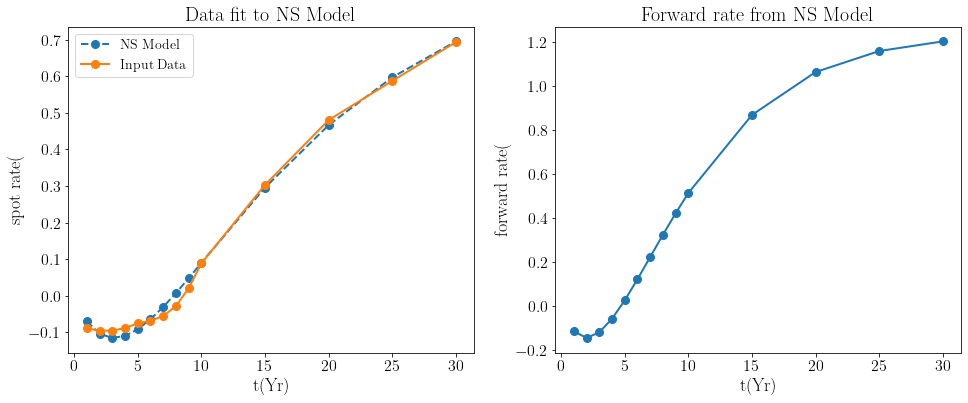

Best fit param: (RSqr=0.999)
tau0=2.00 tau1=3.00 intercept=1.097 beta1=-1.330 beta2=3.153 beta3=-5.379


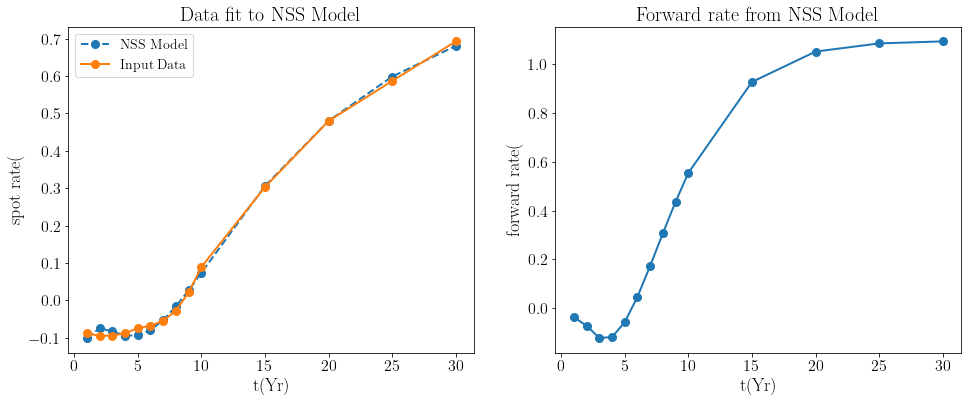

In [300]:
colHdr = ['Tenor','Japan_rates']
zrdata = japan_1230.values

data=pd.DataFrame(zrdata, columns=colHdr)
tIdxName, rateColName = 'Tenor', 'Japan_rates'
tenor, y = data[tIdxName], data[rateColName]

nsm = NSCurveFamily(False)
nsm.estimateParam(tenor, y)

print('Best fit param: (RSqr=%.3f)' % nsm.rsqr)
print('tau=%.2f intercept=%.3f beta1=%.3f beta2=%.3f' % (nsm.tau0, nsm.beta0, nsm.beta1, nsm.beta2) )

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(tenor, nsm.getSpot(tenor), 'o--', label='NS Model')
plt.plot(tenor, y, 'o-', label='Input Data')
plt.title('Data fit to NS Model')
plt.xlabel('t(Yr)')
plt.ylabel('spot rate(%)')
plt.legend()
plt.subplot(122)
plt.plot(tenor, nsm.getFwdRate(tenor), 'o-', label='NS Model')
plt.title('Forward rate from NS Model')
plt.xlabel('t(Yr)')
plt.ylabel('forward rate(%)')
plt.show()

nssm = NSCurveFamily(True)
nssm.estimateParam(tenor, y)

print('Best fit param: (RSqr=%.3f)' % nssm.rsqr)
print('tau0=%.2f tau1=%.2f intercept=%.3f beta1=%.3f beta2=%.3f beta3=%.3f' % (nssm.tau0, nssm.tau1, nssm.beta0, nssm.beta1, nssm.beta2, nssm.beta3) )

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(tenor, nssm.getSpot(tenor), 'o--', label='NSS Model')
plt.plot(tenor, y, 'o-', label='Input Data')
plt.title('Data fit to NSS Model')
plt.xlabel('t(Yr)')
plt.ylabel('spot rate(%)')
plt.legend()
plt.subplot(122)
plt.plot(tenor, nssm.getFwdRate(tenor), 'o-', label='NSS Model')
plt.title('Forward rate from NSS Model')
plt.xlabel('t(Yr)')
plt.ylabel('forward rate(%)')
plt.show()

Japan's interest rates fit the NSS model better than the US rates.

In [301]:
# 6.2 Japan's R Squared Model

japan_param = pd.DataFrame(index = japan.index, columns = ['tau0', 'tau1', 'beta0', 'beta1', 'beta2', 'beta3','RSqr' ] , data = 0 )

In [ ]:
for tt in japan.index:
    print(tt)
    df_tt = japan[japan.index == tt  ]
    df_tt = df_tt.transpose()
    df_tt.reset_index(inplace = True)
    df_tt.rename(columns = {df_tt.columns[0]:'tenor',df_tt.columns[1]:'yields' }, inplace = True)
    df_tt['tenor'] = tau_univ
        
    colHdr = ['Tenor','Japan_rates']
    zrdata = df_tt.values

    data=pd.DataFrame(zrdata, columns=colHdr)
    tIdxName, rateColName = 'Tenor', 'Japan_rates'
    tenor, y = data[tIdxName], data[rateColName]

    nssm = NSCurveFamily(True)
    nssm.estimateParam(tenor, y)

    print('Best fit param: (RSqr=%.3f)' % nssm.rsqr)
    print('tau0=%.2f tau1=%.2f intercept=%.3f beta1=%.3f beta2=%.3f beta3=%.3f' % (nssm.tau0, nssm.tau1, nssm.beta0, nssm.beta1, nssm.beta2, nssm.beta3) )
    japan_param.loc[tt,:] = [nssm.tau0, nssm.tau1, nssm.beta0, nssm.beta1, nssm.beta2, nssm.beta3,nssm.rsqr]

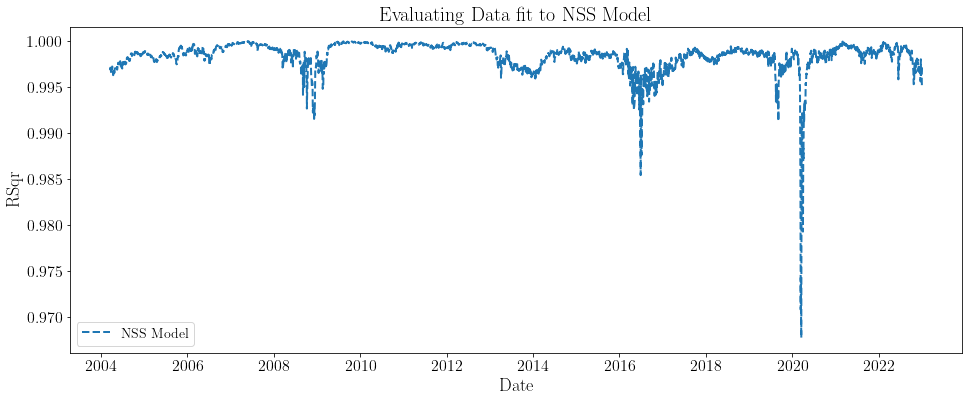

In [303]:
plt.figure(figsize=(16,6))
plt.plot(japan_param.index, japan_param['RSqr'], '--', label='NSS Model')
plt.title('Evaluating Data fit to NSS Model')
plt.xlabel('Date')
plt.ylabel('RSqr')
plt.legend()
plt.show()

The R-squared data for the US fits the NSS model better as R-squared = 1 for the majority of the past 16 years excepct for 2006 and 2022. In contrast the R-squared data for Japan often dips though it usually stays relatively close to 1. 

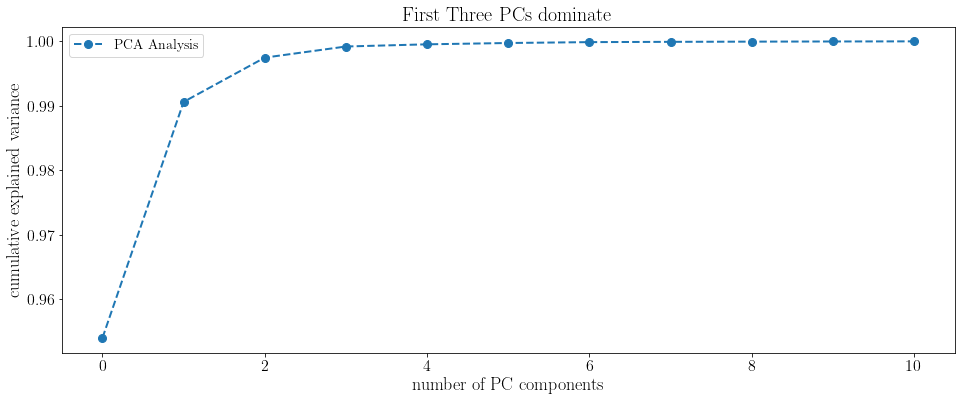

In [304]:
# 6.3 PCA Analysis

X = japan.values
pca = PCA(n_components=11)
pca.fit(X)

plt.figure(figsize=(16,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o--', label='PCA Analysis')
plt.title('First Three PCs dominate')
plt.xlabel('number of PC components')
plt.ylabel('cumulative explained variance')
plt.legend()
plt.show()

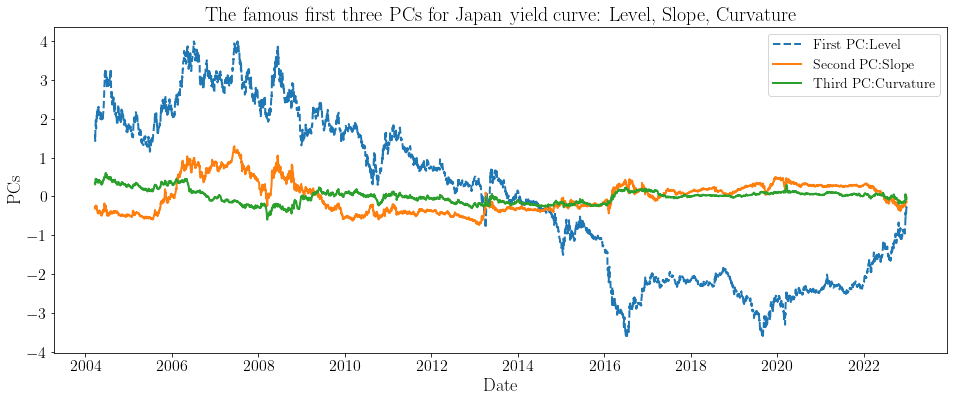

In [305]:
# 6.3 PCs: Level, Slope, and Curvature

df_pc = pd.DataFrame(pca.transform(X))
df_pc.columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11']
df_pc.index = japan.index

plt.figure(figsize=(16,6))
plt.plot(df_pc.index, df_pc.PC1, '--', label='First PC:Level')
plt.plot(df_pc.index, df_pc.PC2, '-', label='Second PC:Slope')
plt.plot(df_pc.index, df_pc.PC3, label='Third PC:Curvature')
plt.title('The famous first three PCs for Japan yield curve: Level, Slope, Curvature')
plt.xlabel('Date')
plt.ylabel('PCs')
plt.legend()
plt.show()

In [306]:
## level means the average of  the all the cross-section rates
japan["rates_level"] = japan.mean(axis = 1)
## slope means the diff between long term bonds and short term bonds  
japan["rates_slope"] = japan["10Y"] - japan["1Y"]
## curve means the diff between slopes of longer term bonds and shorter term bonds
japan["rates_curve"] = 2*japan["5Y"] - japan["10Y"] - japan["1Y"]

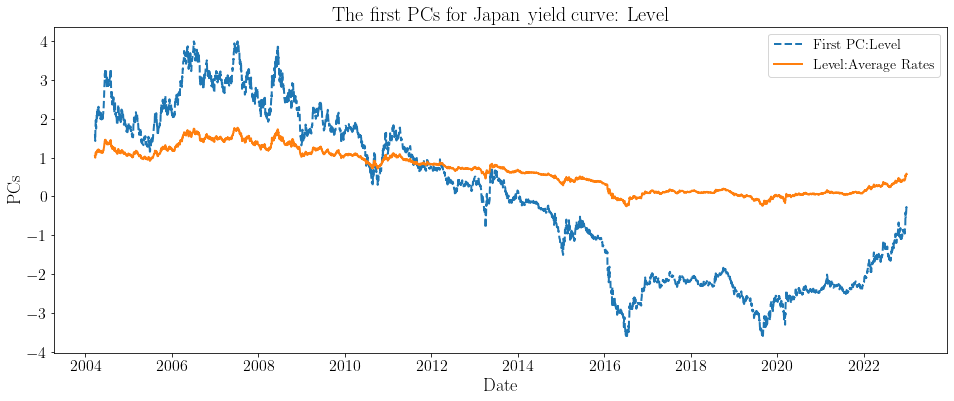

In [307]:
# 6.3 1st PC

plt.figure(figsize=(16,6))
plt.plot(df_pc.index, df_pc.PC1, '--', label='First PC:Level')
plt.plot(df_pc.index, japan.rates_level, label='Level:Average Rates')
plt.title('The first PCs for Japan yield curve: Level')
plt.xlabel('Date')
plt.ylabel('PCs')
plt.legend()
plt.show()

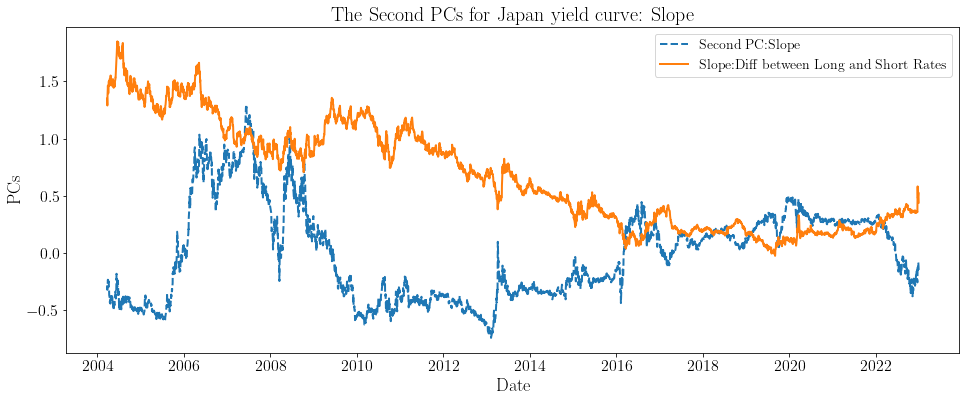

In [308]:
# 6.3 2nd PC

plt.figure(figsize=(16,6))
plt.plot(df_pc.index, df_pc.PC2, '--', label='Second PC:Slope')
plt.plot(df_pc.index, japan.rates_slope, label='Slope:Diff between Long and Short Rates')
plt.title('The Second PCs for Japan yield curve: Slope')
plt.xlabel('Date')
plt.ylabel('PCs')
plt.legend()
plt.show()

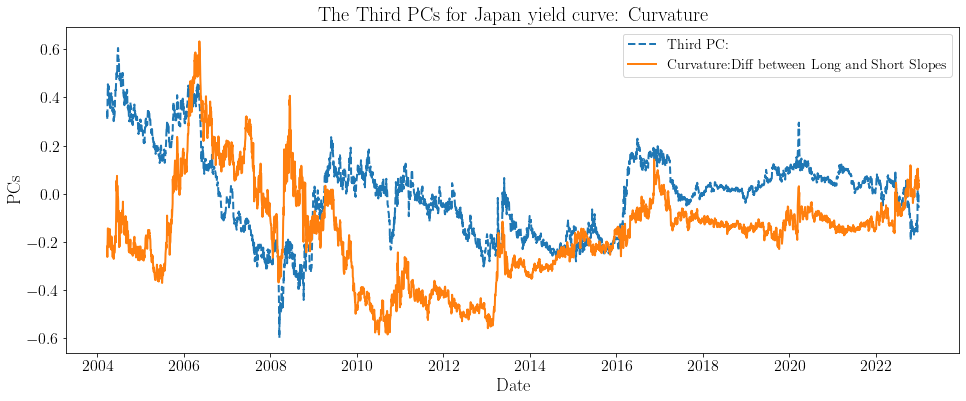

In [309]:
# 6.3 3rd PC

plt.figure(figsize=(16,6))
plt.plot(df_pc.index, df_pc.PC3, '--', label='Third PC:')
plt.plot(df_pc.index, japan.rates_curve, label='Curvature:Diff between Long and Short Slopes')
plt.title('The Third PCs for Japan yield curve: Curvature')
plt.xlabel('Date')
plt.ylabel('PCs')
plt.legend()
plt.show()

The first three principals do not have the same interpretation as the level, slope, and curvature as was the case for the US. We can see this by the disparity in each of the 3 above graphs. While the first 3 principals were close to the actual values for the US, they are different for Japan. 

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%********

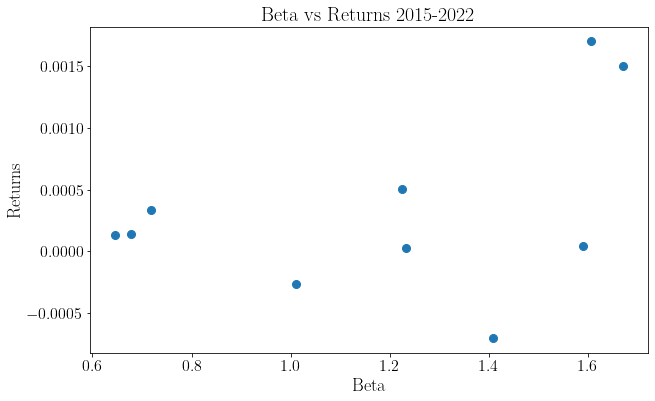

In [310]:
# 7.1 S&P 500 Stocks vs SPY 2015-2022

def plot_beta_2015(stock): 
    data = yfin.download(tickers=[stock, 'SPY', '^IRX'], start='2015-01-01', end='2022-12-31', interval='1d')
    data = data['Close']

    data[stock] = data[stock].pct_change()
    data['SPY'] = data['SPY'].pct_change()

    y, X = dmatrices(f"{stock} ~ SPY", data=data, return_type="dataframe")

    model = sm.OLS(y,X) 

    res = model.fit()

    returns = res.params[0]
    beta = res.params[1]

    return (returns, beta)

stocks = ['APA', 'AMD', 'AAL', 'MSFT', 'NVDA', 'META', 'PEP', 'PFE', 'MCD', 'DIS']

returns = []
beta = []

for stock in stocks:
    returns.append(plot_beta_2015(stock)[0])
    beta.append(plot_beta_2015(stock)[1])

plt.scatter(beta, returns)
plt.title('Beta vs Returns 2015-2022')
plt.xlabel('Beta')
plt.ylabel('Returns')
plt.show()

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%********

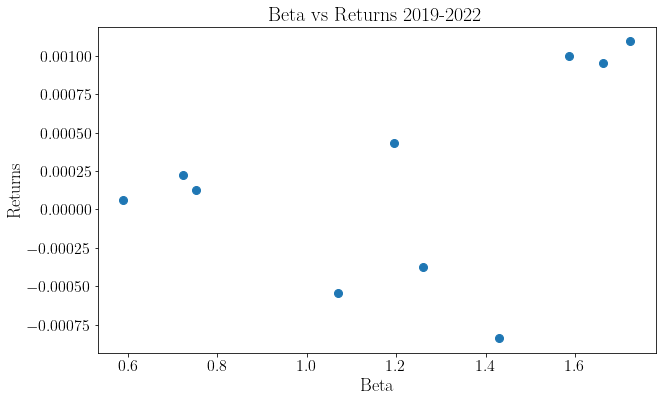

In [311]:
# 7.2 S&P 500 Stocks vs SPY 2019-2022

def plot_beta_2019(stock): 
    data = yfin.download(tickers=[stock, 'SPY', '^IRX'], start='2019-01-01', end='2022-12-31', interval='1d')
    data = data['Close']

    data[stock] = data[stock].pct_change()
    data['SPY'] = data['SPY'].pct_change()

    y, X = dmatrices(f"{stock} ~ SPY", data=data, return_type="dataframe")

    model = sm.OLS(y,X) 

    res = model.fit()

    returns = res.params[0]
    beta = res.params[1]

    return (returns, beta)

stocks = ['APA', 'AMD', 'AAL', 'MSFT', 'NVDA', 'META', 'PEP', 'PFE', 'MCD', 'DIS']

returns = []
beta = []

for stock in stocks:
    returns.append(plot_beta_2019(stock)[0])
    beta.append(plot_beta_2019(stock)[1])

plt.scatter(beta, returns)
plt.title('Beta vs Returns 2019-2022')
plt.xlabel('Beta')
plt.ylabel('Returns')
plt.show()

Between the two graphs, the graph for 2019-2022 has lower expected returns as the highest expected return is now about 0.00105 while the highest was about 0.0017 for 2015-2022. I would hypothesize that this is because the S&P 500 has not done well in the past few years which drives down expected return since it is a higher portion of returns if you start at 2019 than at 2015.